In [71]:
import pandas as pd
from nilearn.plotting import plot_design_matrix
from nilearn.image import load_img
import os
import glob
import matplotlib.pyplot as plt
import numpy as np
from scipy.spatial import distance
import sys
sys.path.append('/home/ubuntu/repos/learning-habits-analysis')
from utils.data import Subject

In [72]:
def load_data(first_lvl_dir, phase, contrast):
    contrast_dir = os.path.join(first_lvl_dir, phase, contrast)
    nii_files = glob.glob(os.path.join(contrast_dir, "*.nii"))
    # sort to have consistent order
    nii_files = sorted(nii_files)
    imgs = [load_img(f) for f in nii_files]
    data = np.stack([img.get_fdata() for img in imgs], axis=-1)
    return data, nii_files

In [73]:
def compare_brain_maps(map1, map2):
    # compute mask
    mask = np.isfinite(map1) & np.isfinite(map2)
    map1_vals = map1[mask]
    map2_vals = map2[mask]
    corr = np.corrcoef(map1_vals.ravel(), map2_vals.ravel())
    return corr[0, 1]

# Reference model: GLM2 (first + second stim pmod)

In [74]:
first_lvl_dir = "/home/ubuntu/data/learning-habits/spm_outputs_noSDC/glm2_combined_2025-11-17-01-52"

contrast= "contrast-02_first_stimxqval"

In [75]:
learning_data, learning_files = load_data(first_lvl_dir, "learning", contrast)
test_data, test_files = load_data(first_lvl_dir, "test", contrast)

In [76]:
corrs = []
for s in range(learning_data.shape[-1]):
    corr = compare_brain_maps(learning_data[...,s], test_data[...,s])
    corrs.append(corr)

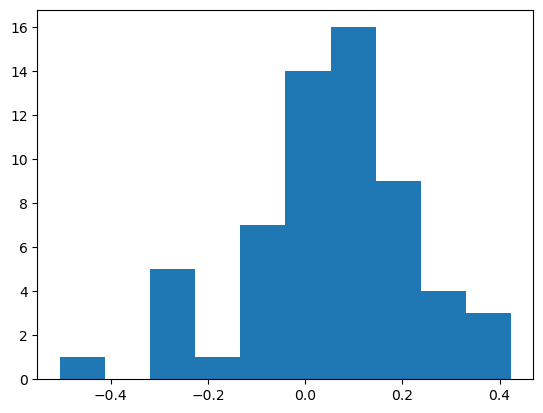

In [77]:
plt.hist(corrs);

# chosen/unchosen pmod

In [78]:
first_lvl_dir = "/home/ubuntu/data/learning-habits/spm_outputs_noSDC/glm2_chosen_2025-11-18-11-32"

contrast= "contrast-03_second_stimxqval_chosen"

In [79]:
learning_data, learning_files = load_data(first_lvl_dir, "learning", contrast)
test_data, test_files = load_data(first_lvl_dir, "test", contrast)

In [80]:
sub_71_idx = [i for i, f in enumerate(test_files) if 'sub-71' in f]
#test_data = np.delete(test_data, sub_71_idx, axis=-1)

In [81]:
corrs = []
for s in range(learning_data.shape[-1]):
    corr = compare_brain_maps(learning_data[...,s], test_data[...,s])
    corrs.append(corr)

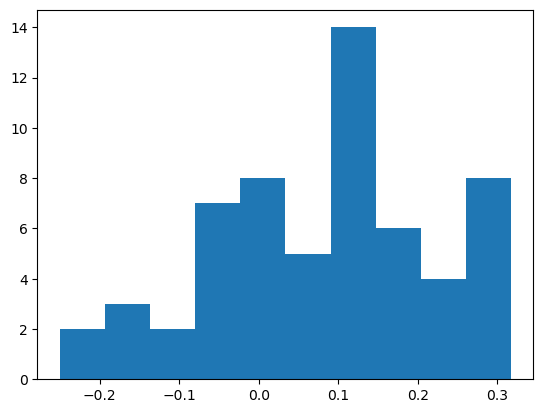

In [82]:
plt.hist(corrs);

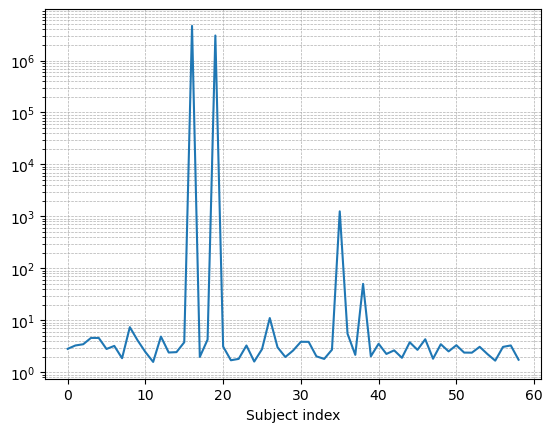

In [101]:
plt.semilogy(np.nanstd(learning_data, axis=(0,1,2)))
plt.xlabel('Subject index')
plt.grid(True, which='both', ls='--', lw=0.5)

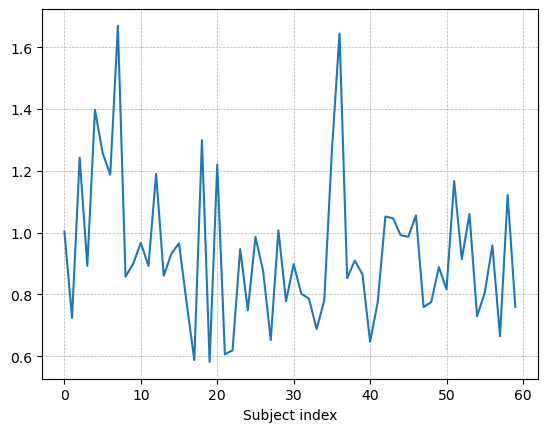

In [103]:
plt.plot(np.nanstd(test_data, axis=(0,1,2)))
plt.xlabel('Subject index')
plt.grid(True, which='both', ls='--', lw=0.5)

In [99]:
flagged = np.where(np.abs(np.nanmean(learning_data, axis=(0,1,2)))>5)
flagged

(array([16, 19, 35, 38]),)

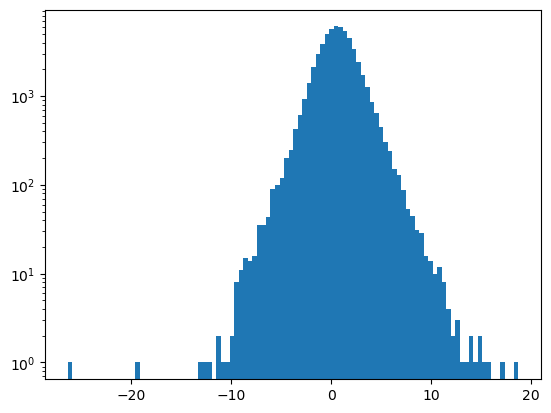

In [96]:
plt.hist((learning_data[...,39].ravel()), bins=100, log=True);

In [85]:
np.where(np.abs(np.nanmean(test_data, axis=(0,1,2)))>1)

(array([], dtype=int64),)

In [56]:
filtered_learning_files = list(np.delete(learning_files, flagged, axis=-1))

# Doing second level using nilearn


In [57]:
from nilearn.glm.second_level import SecondLevelModel
from nilearn.plotting import plot_stat_map

In [58]:
X_RL = pd.DataFrame([1] * len(filtered_learning_files), columns=['RL_value'])

In [59]:
second_level_model_RL = SecondLevelModel()
second_level_model_RL = second_level_model_RL.fit(filtered_learning_files, design_matrix=X_RL)

In [60]:
RL_WB_zmap = second_level_model_RL.compute_contrast(output_type='z_score')

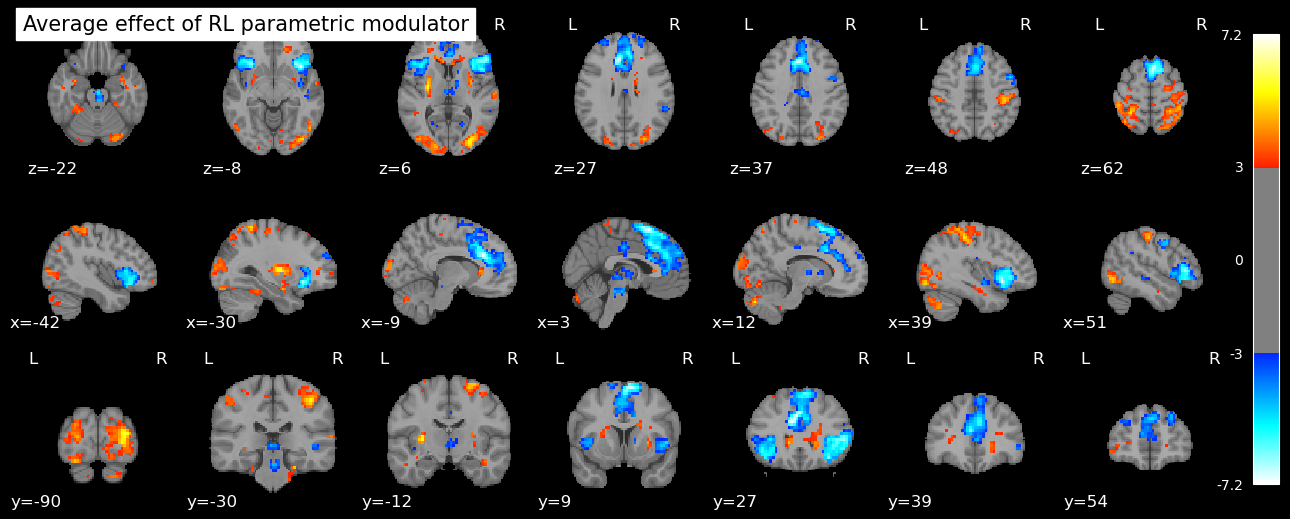

In [63]:
plot_stat_map(RL_WB_zmap, threshold=3, black_bg=True, display_mode='mosaic', title='Average effect of RL parametric modulator')


In [48]:
X_RL = pd.DataFrame([1] * len(test_files), columns=['RL_value'])

In [49]:
second_level_model_RL = SecondLevelModel()
second_level_model_RL = second_level_model_RL.fit(test_files, design_matrix=X_RL)

In [50]:
RL_WB_zmap = second_level_model_RL.compute_contrast(output_type='z_score')

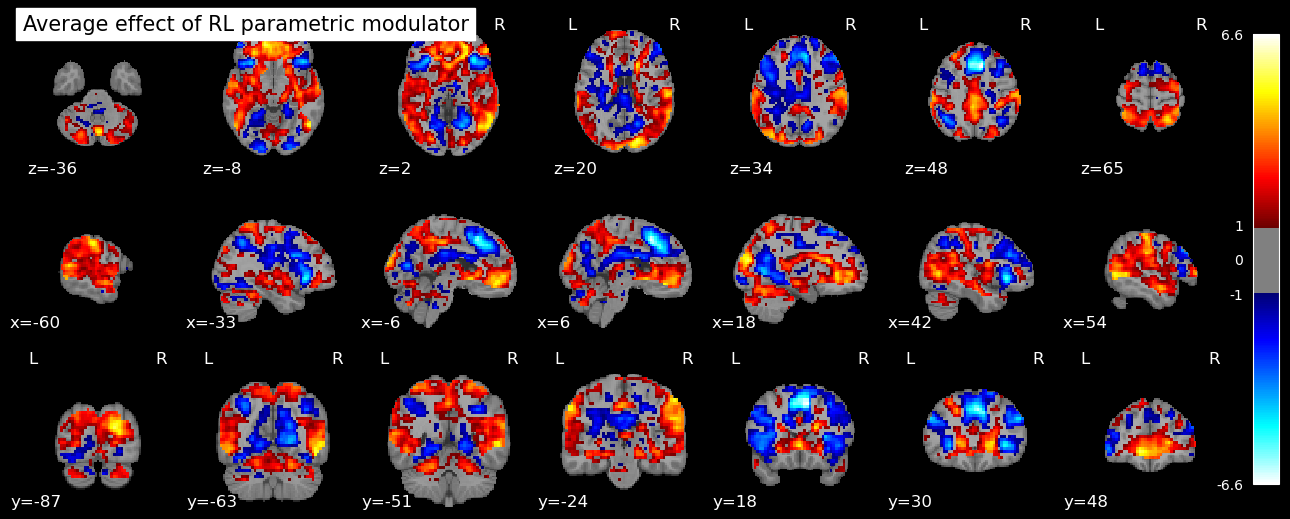

In [51]:
plot_stat_map(RL_WB_zmap, threshold=1, black_bg=True, display_mode='mosaic', title='Average effect of RL parametric modulator')
